# Testing
### Bevölkerung nach Religion, seit 1850


Beschreibung
Diese Daten beschreiben die ständige Wohnbevölkerung der Stadt Zürich und basieren auf der Volkszählung und der Strukturerhebung des Bundesamts für Statistik.

Bei der Volkszählung sind Personen aller Altersjahre enthalten, bei der Strukturerhebung bloss 15-Jährige und Ältere. Weitere Informationen finden Sie unter Bemerkung.

Datum: 15.03.2022


### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [5]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
#import leafmap

import requests
import io


In [6]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [7]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [8]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [9]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [10]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 11 datenstand:  9 time.struct_time(tm_year=2022, tm_mon=11, tm_mday=10, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=314, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [11]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [12]:
package_name = "bfs_ste_bev_religion_seit1850_od3150"

In [13]:
dataset_name = "BEV315OD3150.csv"

**Statische Pfade in DWH-Dropzones**

In [14]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [15]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [16]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [17]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [18]:
from IPython.display import Markdown as md

In [19]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_ste_bev_religion_seit1850_od3150 

In [20]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bfs_ste_bev_religion_seit1850_od3150 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [21]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [22]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_ste_bev_religion_seit1850_od3150/download/BEV315OD3150.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [23]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['Jahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['Jahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


Jahr           datetime64[ns]
Religion               object
AntBev                float64
untAntBevKI           float64
obAntBevKI            float64
dtype: object

Berechne weitere Attribute falls notwendig

In [24]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        Jahr_str = lambda x: x.Jahr.astype(str),
    )
    .sort_values('Jahr', ascending=False)
    )
data2betested.dtypes

Jahr           datetime64[ns]
Religion               object
AntBev                float64
untAntBevKI           float64
obAntBevKI            float64
Jahr_str               object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [25]:
#data2betested.head(6)

In [26]:
data2betested.dtypes

Jahr           datetime64[ns]
Religion               object
AntBev                float64
untAntBevKI           float64
obAntBevKI            float64
Jahr_str               object
dtype: object

In [27]:
data2betested.shape

(124, 6)

Beschreibe einzelne Attribute

In [28]:
data2betested.describe()

,AntBev,untAntBevKI,obAntBevKI
count,124,59,59
mean,21,16,18
std,22,13,14
min,0,0,0
25%,1,3,4
50%,17,20,22
75%,30,28,29
max,93,42,44


Wie viele Nullwerte gibt es im Datensatz?

In [29]:
data2betested.isnull().sum()

Jahr            0
Religion        0
AntBev          0
untAntBevKI    65
obAntBevKI     65
Jahr_str        0
dtype: int64

Welches sind die Quartiere ohne Werte bei AnzBestWir?

In [30]:
data2betested[np.isnan(data2betested.untAntBevKI)]

,Jahr,Religion,AntBev,untAntBevKI,obAntBevKI,Jahr_str
57,2000-01-01,Evangelisch-reformiert,32,NaN,NaN,2000-01-01
119,2000-01-01,Christkatholisch,0,NaN,NaN,2000-01-01
3,2000-01-01,Ohne Religionszugehörigkeit,17,NaN,NaN,2000-01-01
72,2000-01-01,Muslimisch,6,NaN,NaN,2000-01-01
99,2000-01-01,Jüdisch,1,NaN,NaN,2000-01-01
...,...,...,...,...,...,...
16,1860-01-01,Römisch-katholisch,9,NaN,NaN,1860-01-01
43,1860-01-01,Evangelisch-reformiert,90,NaN,NaN,1860-01-01
15,1850-01-01,Römisch-katholisch,7,NaN,NaN,1850-01-01
42,1850-01-01,Evangelisch-reformiert,93,NaN,NaN,1850-01-01


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [31]:
data2betested = data2betested.set_index("Jahr")

In [32]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2020-01-01 to 1850-01-01
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Religion     124 non-null    object 
 1   AntBev       124 non-null    float64
 2   untAntBevKI  59 non-null     float64
 3   obAntBevKI   59 non-null     float64
 4   Jahr_str     124 non-null    object 
dtypes: float64(3), object(2)
memory usage: 5.8+ KB


Int64Index([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2000, 1990, 1980,
            1970, 1960, 1950, 1941, 1930, 1920, 1910, 1900, 1888, 1880, 1870, 1860, 1850],
           dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [33]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [34]:
data2betested.loc["2020"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,Religion,AntBev,untAntBevKI,obAntBevKI,Jahr_str
Jahr,,,,,
2020-01-01,Christkatholisch,0,0,0,2020-01-01
2020-01-01,Jüdisch,1,1,1,2020-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Bildungsstand

In [44]:
data2betested.columns
data2betested

,Religion,AntBev,untAntBevKI,obAntBevKI,Jahr_str
Jahr,,,,,
2020-01-01,Christkatholisch,0,0,0,2020-01-01
2020-01-01,Jüdisch,1,1,1,2020-01-01
2020-01-01,Römisch-katholisch,25,24,25,2020-01-01
2020-01-01,Evangelisch-reformiert,18,17,18,2020-01-01
2020-01-01,Ohne Religionszugehörigkeit,43,42,44,2020-01-01
...,...,...,...,...,...
1860-01-01,Römisch-katholisch,9,NaN,NaN,1860-01-01
1860-01-01,Evangelisch-reformiert,90,NaN,NaN,1860-01-01
1850-01-01,Römisch-katholisch,7,NaN,NaN,1850-01-01


In [46]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1860":"2020"]\
    .groupby(['Jahr', 'Jahr_str', 'Religion']) \
    .agg(mean_AntBev=('AntBev', 'mean')
        ,median_AntBev=('AntBev', 'median')
        ) \
    .sort_values('Jahr', ascending=True) 

myAgg.reset_index().head(3)

,,,mean_AntBev,median_AntBev
Jahr,Jahr_str,Religion,,


In [37]:
myTitle="Anteil der Wohnbevölkerung nach Religion seit 1850"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['Religion'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('mean_AntBev>0'), title=myTitle).encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('mean_AntBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('Religion', legend=alt.Legend(title="Religion", orient="right"))  
    ,tooltip=['Jahr_str', 'Religion','mean_AntBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

C:\Users\sszsim\AppData\Local\Continuum\anaconda3\lib\site-packages\altair\utils\core.py:185: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  warnings.warn(


alt.LayerChart(...)

#### Barcharts mit Seaborn

In [38]:
data2betested.columns

Index(['Religion', 'AntBev', 'untAntBevKI', 'obAntBevKI', 'Jahr_str'], dtype='object')

In [39]:
myAgg.head()

,,,mean_AntBev,median_AntBev
Jahr,Jahr_str,Religion,,


In [40]:
#help(sns.catplot)     

In [41]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

In [42]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr_str"
            , y="mean_AntBev"
            , hue="Religion"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAgg.loc["2000":"2020"].reset_index()
           )
myHist.set_xlabels('', fontsize=11) # not set_label
myHist.set_ylabels('Ant. Pers.', fontsize=11)


ValueError: min() arg is an empty sequence

In [43]:
data2betested.columns

Index(['Religion', 'AntBev', 'untAntBevKI', 'obAntBevKI', 'Jahr_str'], dtype='object')

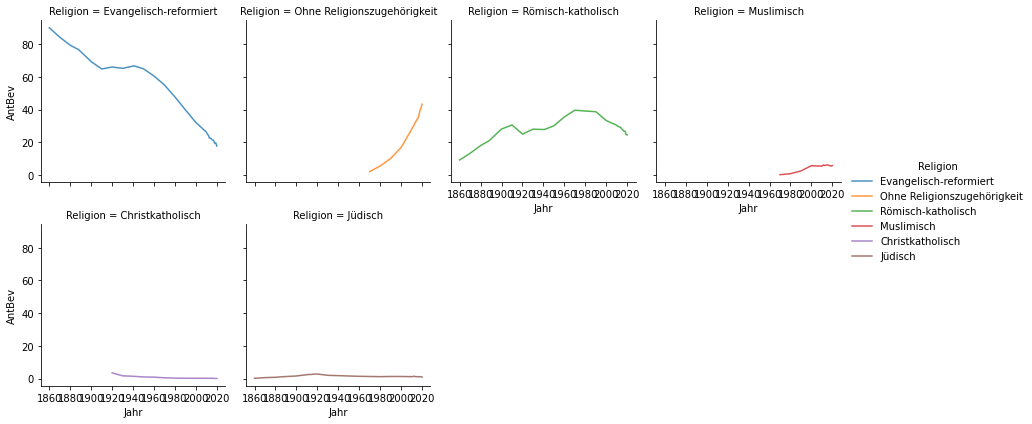

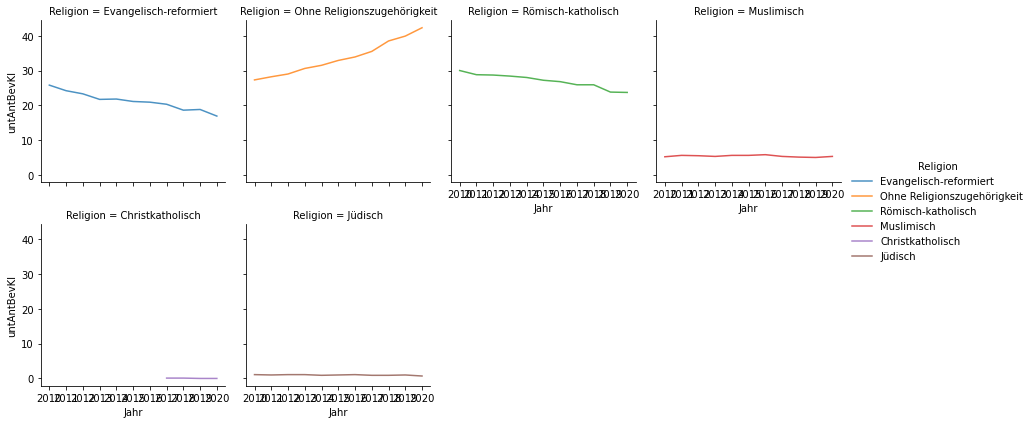

In [69]:
g2 = sns.FacetGrid(data2betested.loc["1860":"2020"].sort_values('AntBev',ascending=False).reset_index(), col="Religion", hue="Religion", col_wrap=4, height=3,)
g2.map(sns.lineplot, "Jahr","AntBev",alpha=.8)
g2.add_legend()

g3 = sns.FacetGrid(data2betested.loc["1860":"2020"].sort_values('AntBev',ascending=False).reset_index(), col="Religion", hue="Religion", col_wrap=4, height=3,)
g3.map(sns.lineplot, "Jahr","untAntBevKI",alpha=.8)
g3.add_legend()


## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=32&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------